# FPCM & source localization: demonstration

May 2025

Daria Kleeva 

dkleeva@gmail.com

## Import

In [1]:
import mne
import os
import sys
import importlib
sys.path.append('/home/dkleeva/Projects/dkleeva/Epilepsy/src/')
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from source_loc import rap_music_scan,fit_spike_dipoles,plot_modeled_topos,plot_dipoles_2d
from utils import compute_performance
from fpcm_detector import detect_spikes_fpcm
from summary import make_epochs, plot_average_joint,plot_spike_topographies,overlay_spline_fit_grid

In [2]:
os.chdir('/home/dkleeva/Projects/dkleeva/Epilepsy/')
SUBJECT='Simulated patient'

In [3]:
raw = mne.io.read_raw_fif(f'/home/dkleeva/Projects/dkleeva/Epilepsy/data/{SUBJECT}/Raw MEG/sim_raw.fif')
raw.load_data()
raw.filter(1,40)
raw.pick('grad')
raw.crop(0,100) #for quick demo
true_peaks = [float(f"{i}.2") for i in range(0, 100)]

Opening raw data file /home/dkleeva/Projects/dkleeva/Epilepsy/data/Simulated patient/Raw MEG/sim_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 0 ... 599499 =      0.000 ...   599.499 secs
Ready.
Reading 0 ... 599499  =      0.000 ...   599.499 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    3.5s


## Detection

In [4]:
results = detect_spikes_fpcm(
    raw,
    peak_hw_ms = 30, # Half-width of the sharp spike (in milliseconds)
    wave_hw_ms = 90, # Half-width of the slow wave following the spike (in milliseconds)
    bkg_coeff   = 3, # Signal-to-noise ratio
    err_peak_th = 0.3, # Maximum allowed relative fitting error for the spike segment
    err_wave_th = 0.9, # Maximum allowed relative fitting error for the wave segment
    hit_threshold = 3, # Minimum number of channels that must agree on a spike to accept it
) 

In [5]:
metrics = compute_performance(
    true_latencies_s = true_peaks,  
    results          = results,                
    raw              = raw,                    
    tolerance_ms     = 40,                     
)

Spike detection performance
TP          : 97
FP          : 7
FN          : 3
precision   : 0.9327
recall      : 0.9700
f1          : 0.9510
FPR_per_min : 4.2000
Matched within ±40 ms (total matches 97)


Not setting metadata
104 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 104 events and 1001 original time points ...
1 bad epochs dropped
No projector specified for this dataset. Please consider the method self.add_proj.


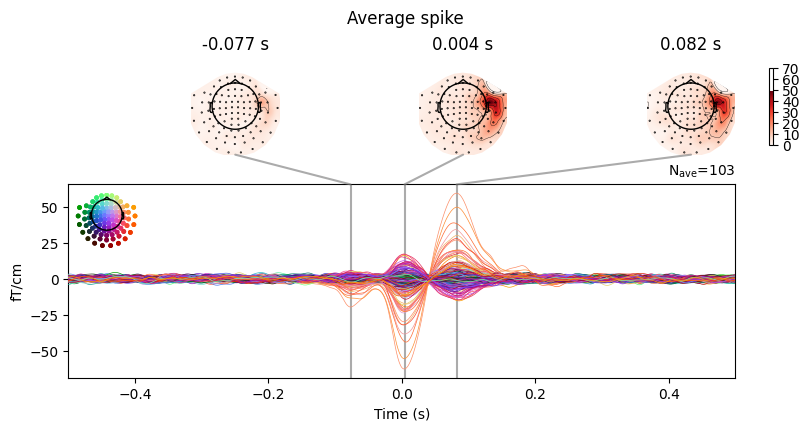

In [6]:
epochs = make_epochs(raw, results, tmin=-0.5, tmax=0.5)
plot_average_joint(epochs, title='Average spike')
plt.show()

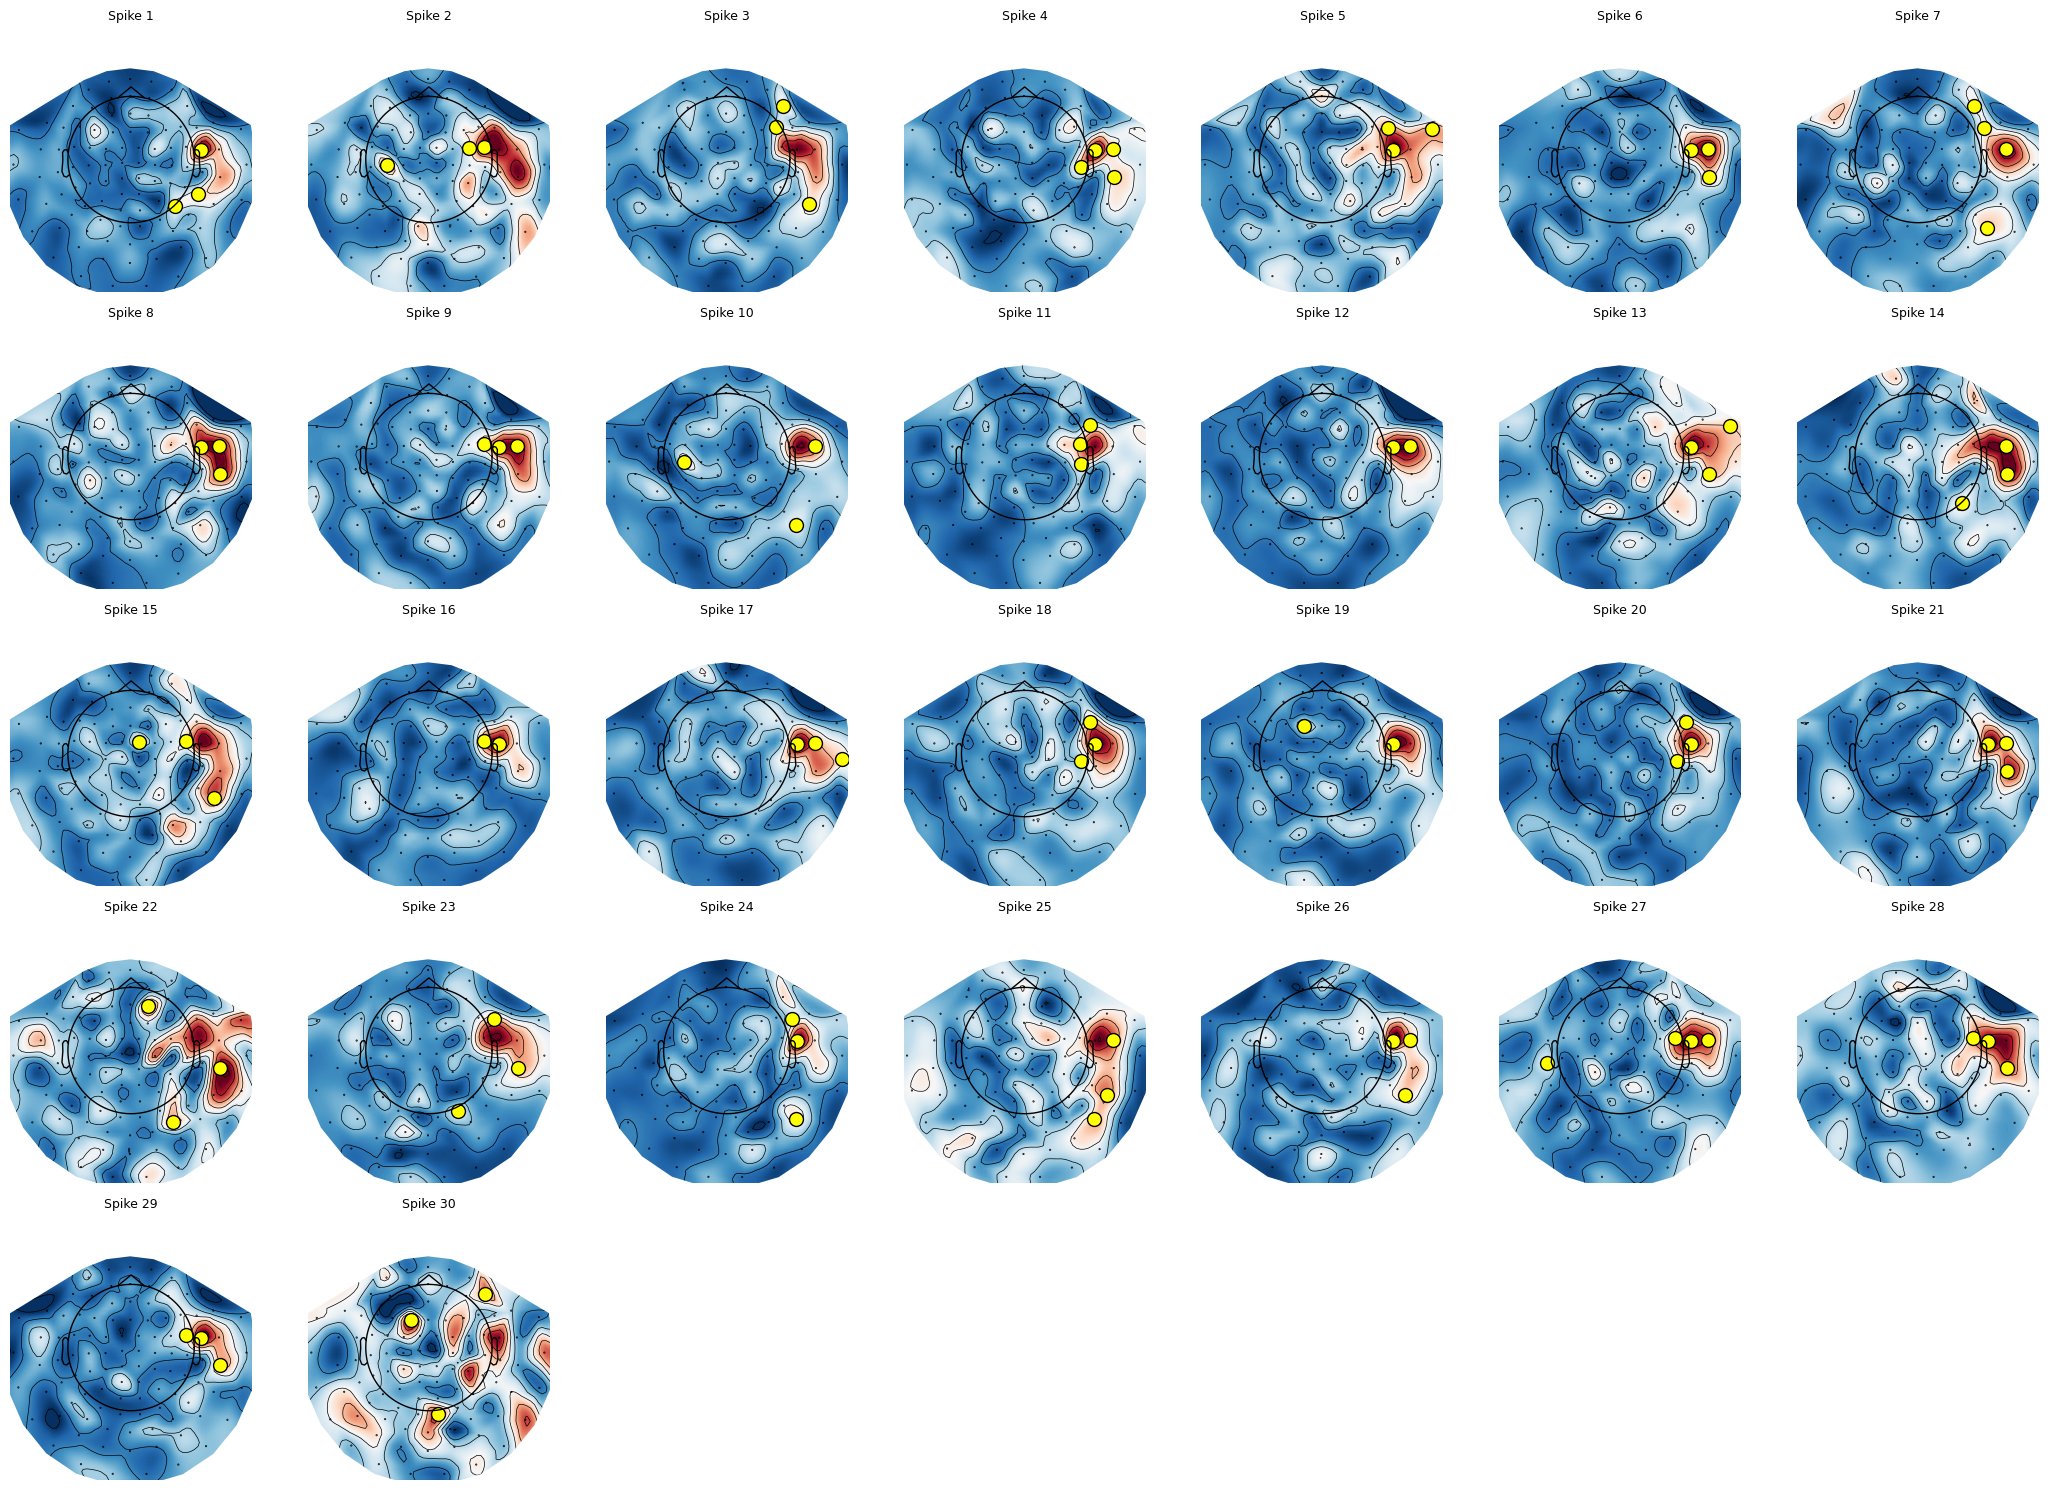

In [22]:
# Each subplot shows the spatial distribution of MEG signal at spike peak.   
# Yellow dots indicate the "hit" channels that contributed to detection.

# Show only first 30 spikes for the fast rendering
num_show=30
results_short=results.copy()
for key in ['peaks_samples', 'events']:
    results_short[key]=results_short[key][:num_show]

plot_spike_topographies(raw, results_short, n_cols=7) #Replace results_short with results for the full set
plt.show()

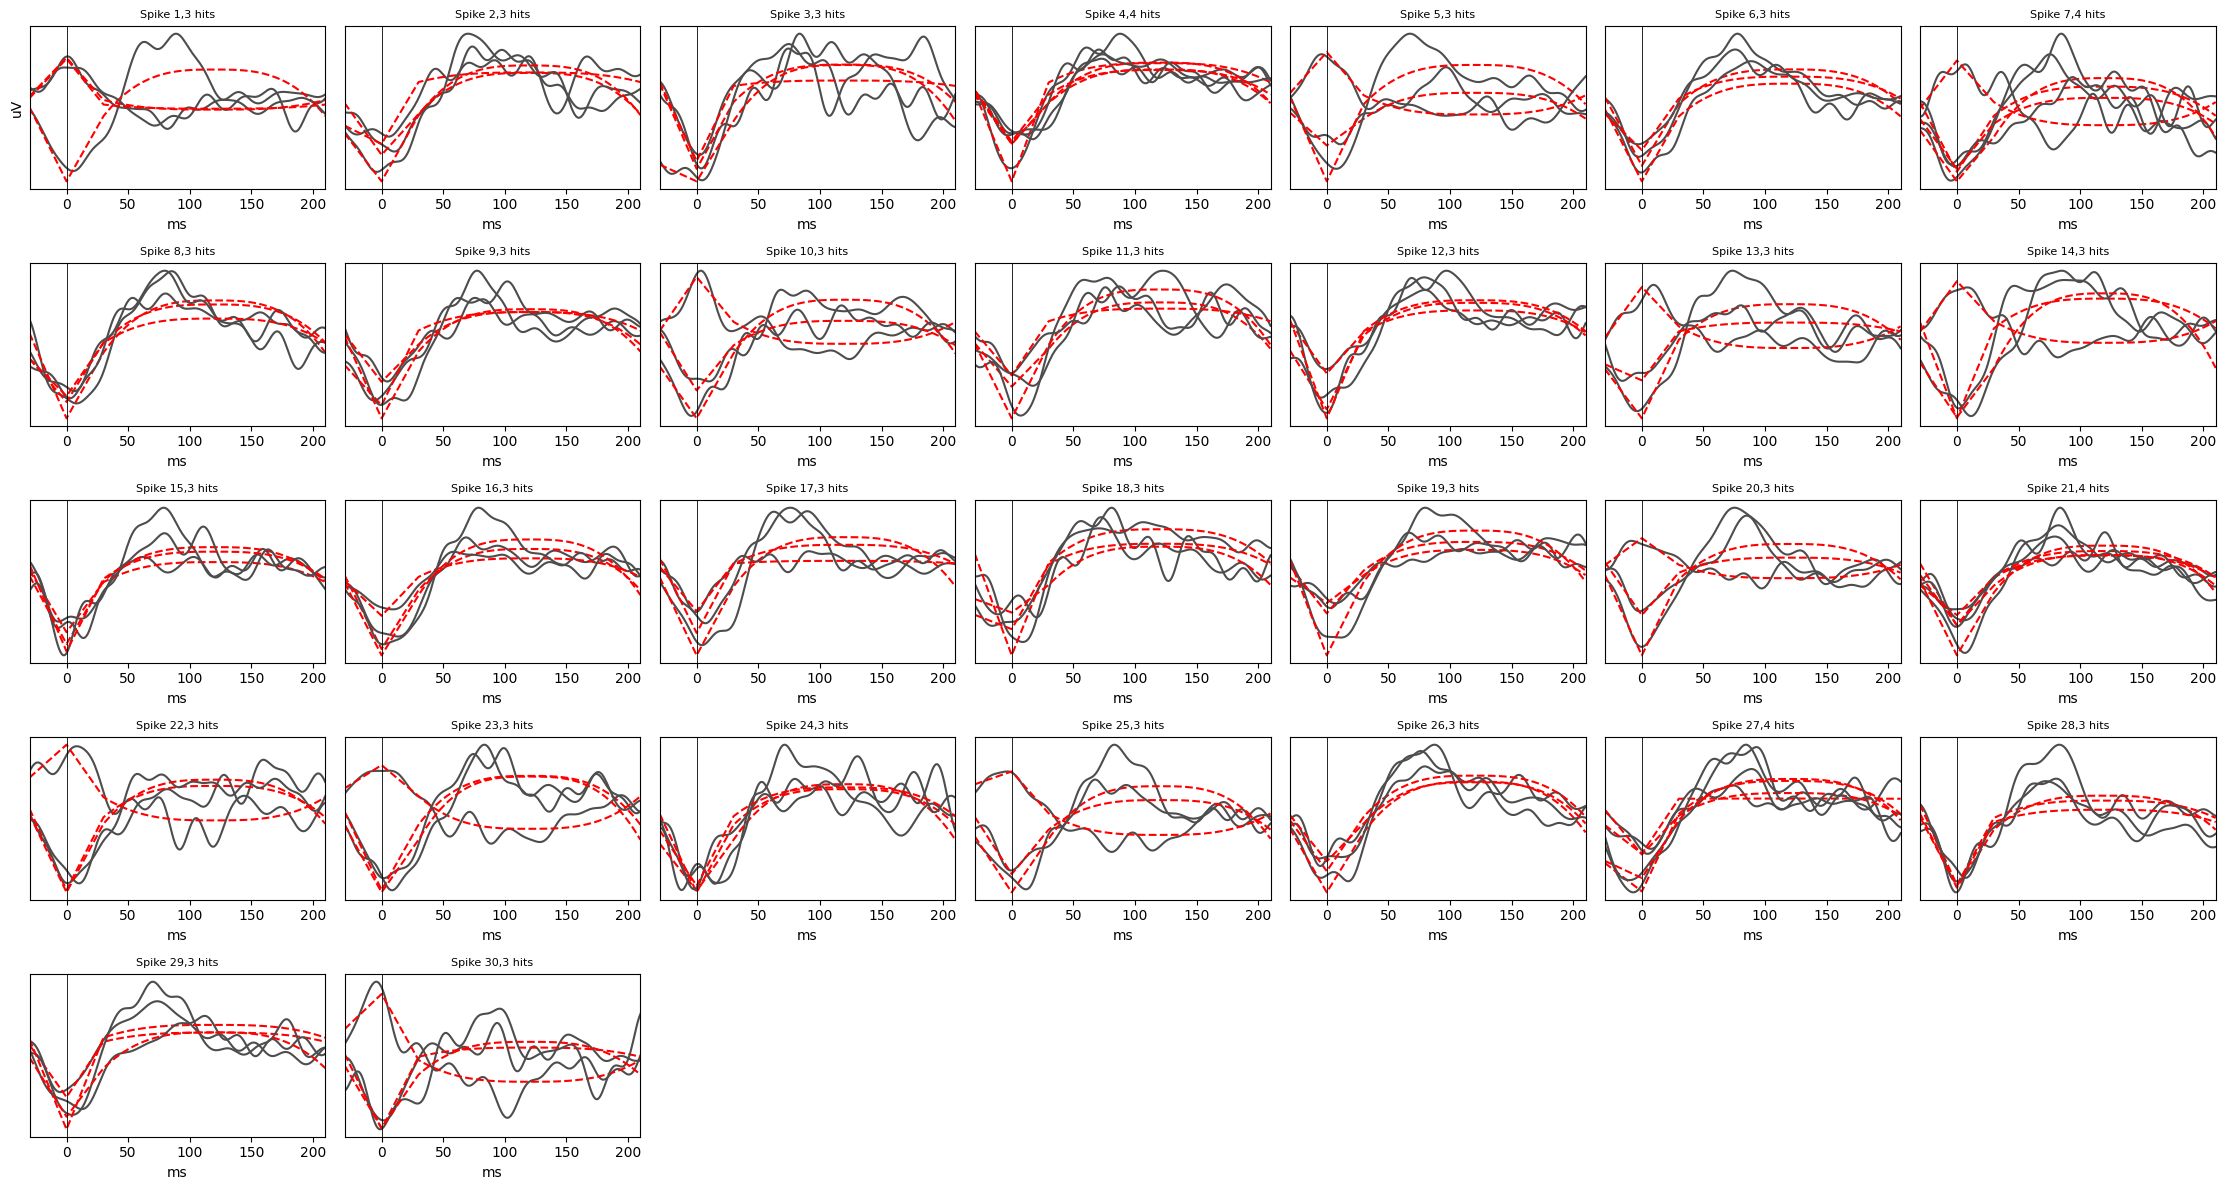

In [23]:
#Each subplot shows the raw data (black) and the fitted spline (red dashed) for one spike and one channel.
overlay_spline_fit_grid(raw, results_short, n_cols=7, unit='uV',
                                data_kw=dict(color='0.3'),
                                spline_kw=dict(color='r', ls='--'))
#Replace results_short with results for the full set
plt.show()

## Dipole fitting

In [9]:
# Create the cortical source space, compute BEM model and build the forward model
subjects_dir = '/home/dkleeva/mne_data/MNE-fsaverage-data/'
subject      = "fsaverage"
src = mne.setup_source_space(
    subject, spacing="ico4",  
    add_dist=False, subjects_dir=subjects_dir, verbose=False)
model = mne.make_bem_model(subject=subject, subjects_dir=subjects_dir )
bem = mne.make_bem_solution(model)
trans = "fsaverage"
fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem, 
                                eeg=False, meg=epochs.get_channel_types(picks='data', unique=True)[0], n_jobs=3)

Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is  -0.21 -19.38  -0.23 mm
outer skull CM is  -0.19 -19.34  -0.49 mm
inner skull CM is  -0.53 -21.10   6.21 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Checking distance between outer skin  and outer skull surfaces...
Minimum distance between the outer skin  and outer skull surfaces is approximately    1.6 mm
Checking distance between outer skull and inner skull surfaces...
Minimum distance between the outer skull and inner skull surfaces is approximately    5.4 mm
Surfaces passed the basic topology checks.
Complete.

Three-layer model surfaces loaded.
Computing the linear collocation solution...
    Matrix coefficients...
     

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Found    0/1953 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 5418.2 ms
Checking surface interior status for 2562 points...
    Found  561/2562 points inside  an interior sphere of radius   47.7 mm
    Found    0/2562 points outside an exterior sphere of radius   98.3 mm
    Found    0/2001 points outside using surface Qhull


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    5.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


    Found    0/2001 points outside using solid angles
    Total 2562/2562 points inside the surface
Interior check completed in 302.1 ms

Checking surface interior status for 204 points...
    Found   0/204 points inside  an interior sphere of radius   83.4 mm
    Found  40/204 points outside an exterior sphere of radius  133.7 mm
    Found 164/164 points outside using surface Qhull
    Found   0/  0 points outside using solid angles
    Total 0/204 points inside the surface
Interior check completed in 16.6 ms

Composing the field computation matrix...


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concu

Computing MEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.



Finished.


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


In [10]:
# Apply RAP-MUSIC algorithm to each spike using the forward model.  

fit_res = fit_spike_dipoles(
    epochs, # Spike-centered epochs (each epoch = one spike)
    fwd, # Forward model (leadfield matrix)
    t_window=(-0.1, 0.1),  # Time window (in seconds) around the spike apex used for source fitting
    thr_music=0.8, # Threshold for subspace correlation (only dipoles with corr > thr_music are accepted)
    thr_svd=0.95,  # Variance threshold for the signal subspace (used in SVD for RAP-MUSIC)
)

Spike   0: found 1 dipole(s)  corr=[0.86205668]
Spike   1: found 1 dipole(s)  corr=[0.83574538]
Spike   2: found 1 dipole(s)  corr=[0.80635818]
Spike   3: found 1 dipole(s)  corr=[0.82057891]
Spike   4: found 1 dipole(s)  corr=[0.83508393]
Spike   5: found 1 dipole(s)  corr=[0.82603953]
Spike   6: found 1 dipole(s)  corr=[0.83421554]
Spike   7: found 1 dipole(s)  corr=[0.82537447]
Spike   8: found 1 dipole(s)  corr=[0.82003735]
Spike   9: found 1 dipole(s)  corr=[0.86662487]
Spike  10: found 1 dipole(s)  corr=[0.88403785]
Spike  11: found 1 dipole(s)  corr=[0.85543272]
Spike  12: found 1 dipole(s)  corr=[0.837221]
Spike  13: found 1 dipole(s)  corr=[0.8644932]
Spike  14: found 1 dipole(s)  corr=[0.84391748]
Spike  15: found 1 dipole(s)  corr=[0.85963114]
Spike  16: found 1 dipole(s)  corr=[0.83755895]
Spike  17: found 1 dipole(s)  corr=[0.81988674]
Spike  18: found 1 dipole(s)  corr=[0.84146963]
Spike  19: found 3 dipole(s)  corr=[0.83841613 0.83749537 0.83862946]
Spike  20: found 1 di

Using fsaverage-head-dense.fif for head surface.
    1 BEM surfaces found
    Reading a surface...
[done]
    1 BEM surfaces read


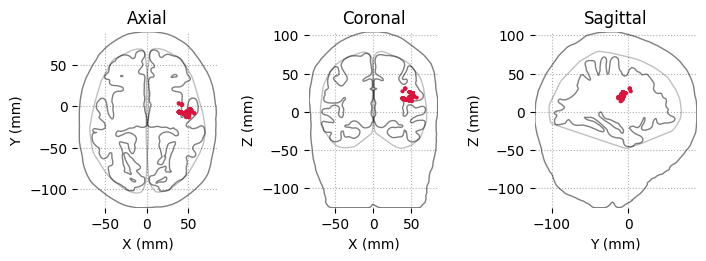

In [11]:
# All localized dipoles are projected onto the fsaverage cortical surface.  
plot_dipoles_2d(
        fit_res, 
        trans=subject,       
        subject=subject,
        subjects_dir=os.getenv("SUBJECTS_DIR"),
        color="crimson",
)
plt.show()

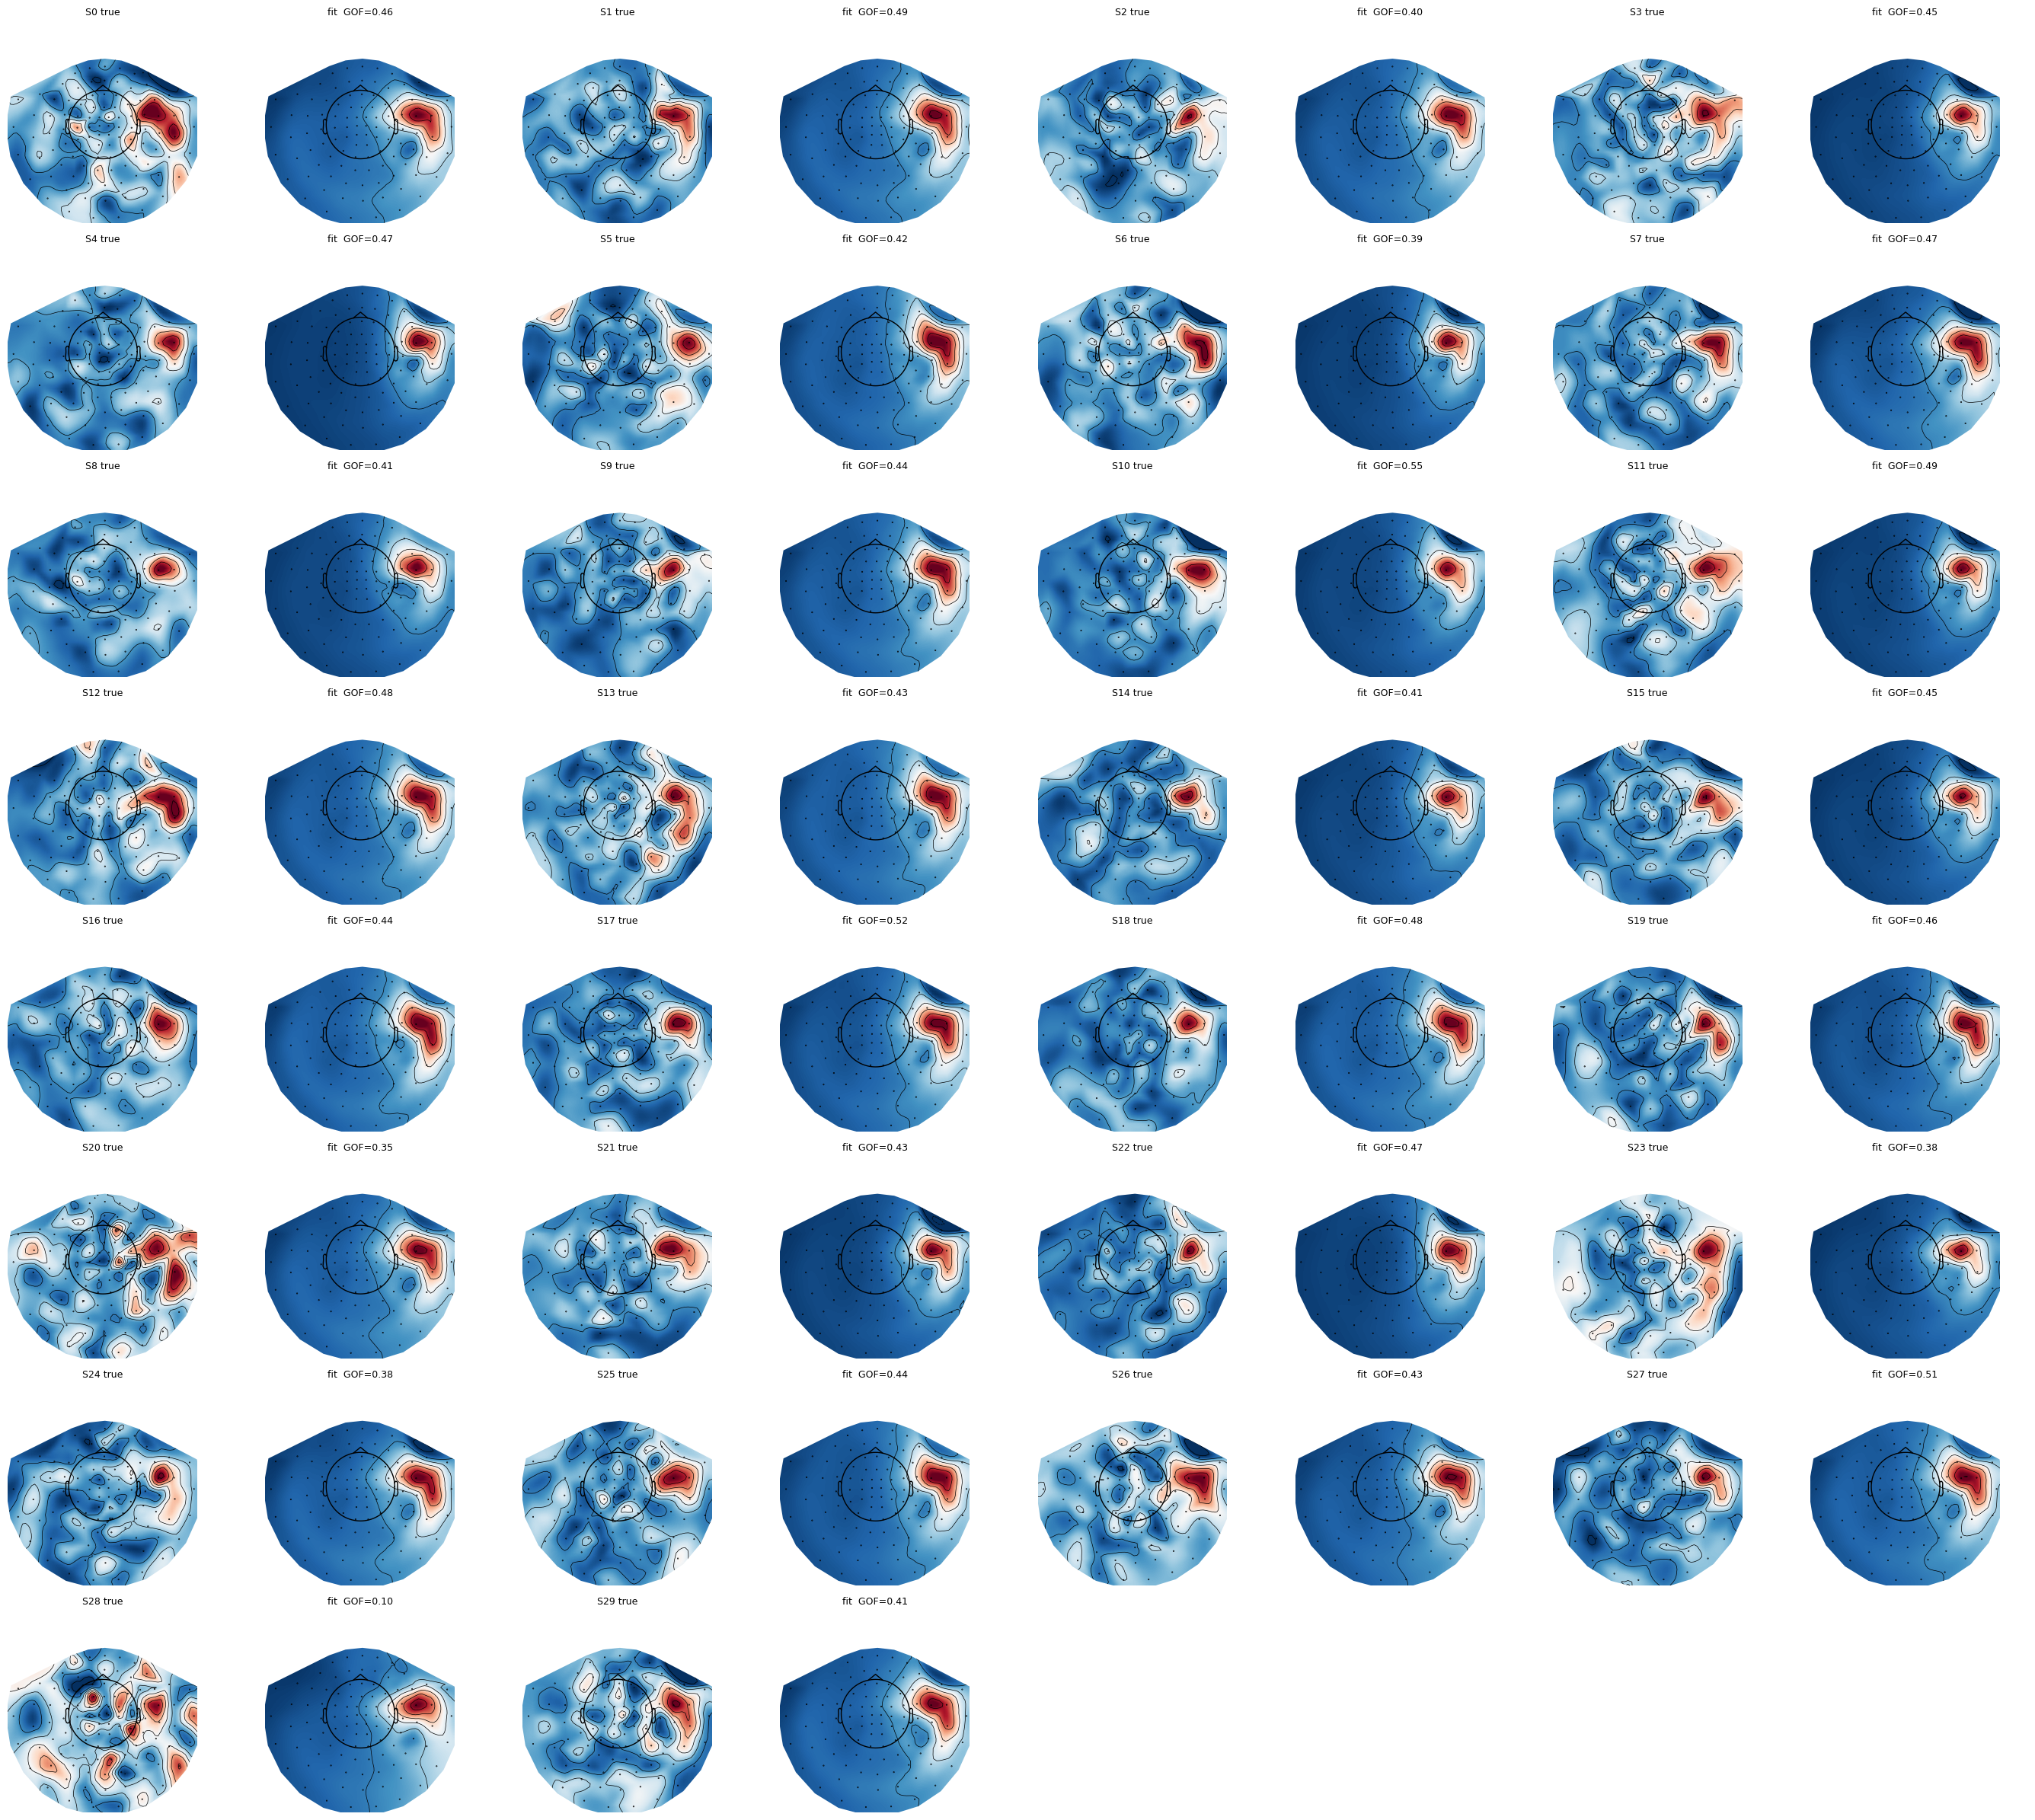

In [17]:
# For each spike, compare the measured topography at the spike peak  
# with the synthetic topography generated from the fitted dipoles.  

# Show first 30 for fast rendering
show_num=30
fit_res_short=fit_res.copy()
for key in fit_res_short.keys():
    fit_res_short[key]=fit_res_short[key][:show_num]

plot_modeled_topos(epochs[:show_num], fit_res_short, fwd,
                              n_cols=4, cmap="RdBu_r", vmax=None)
plt.show()